In [1]:
import torch
from torch import argmax, argsort, relu
from torchvision.models import resnet18
from torchsummary import summary
from utils import classify
import cv2
import numpy as np
from matplotlib import pyplot as plt
from captum.attr import LayerLRP, LayerActivation
from copy import deepcopy
import os
from male import get_important_neurons

/home/adamwsl/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
%load_ext autoreload

In [3]:
filename = 'coral reef.jpg'

In [4]:
import torch
from torchvision.models import resnet18
model = resnet18(pretrained=True)
_ = model.eval()
# summary(model, (3, 224, 224))

In [5]:
%autoreload 2
probabilities, top_probabilities, categories, input_batch, input_tensor = classify(filename, model)

In [6]:
image_center_resized = input_tensor.numpy()
image_center_resized = np.transpose(image_center_resized, (1, 2, 0))

In [7]:
import pandas as pd
import os
descriptions = pd.read_csv(os.path.join('milan_results', 'resnet18_imagenet.csv'))
#layer_names = ['conv1'] + ['layer' + str(i) for i in range(1, 5, 1)]
layer_names = ['layer4']
layer_map = {'conv1' : model.bn1, 
             'layer1' : model.layer1[1].bn2, 
             'layer2' : model.layer2[1].bn2, 
             'layer3' : model.layer3[1].bn2, 
             'layer4' : model.layer4[1].bn2}

In [8]:
how_much_highest = 10

In [9]:
per_layer_results, per_layer_activations = get_important_neurons(how_much_highest, 
                                                                 input_batch, 
                                                                 model, 
                                                                 layer_names, 
                                                                 layer_map, 
                                                                 descriptions, 
                                                                 probabilities)

/home/adamwsl/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [10]:
print(categories[0])

coral reef


In [11]:
from utils import wikipedify
wiki_text = wikipedify(categories[0])

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

tokenized_wiki_text = word_tokenize(wiki_text)
tokenized_wiki_text = [w.lower() for w in tokenized_wiki_text if (not w.lower() in stop_words) and w.lower().isalpha()]

for layer_name, results in per_layer_results.items():
    for unit_id, description in results.items():
        tokenized_description = word_tokenize(description)
        filtered_sentence = [w.lower() for w in tokenized_description if (not w.lower() in stop_words) and w.lower().isalpha()]
        results[unit_id] = filtered_sentence

In [13]:
imagenet_banned = ['anim', 'line', 'color', 'similar', 'pattern', 'object', 'edg', 'head']

In [14]:
# importing modules
from nltk.stem import PorterStemmer
  
ps = PorterStemmer()


per_layer_results_stemmed = {layer_name : dict() for layer_name in per_layer_results.keys()}
wiki_text_stemmed = [ps.stem(w) for w in tokenized_wiki_text]
for layer_name, results in per_layer_results.items():
    for unit_id, description in results.items():
        per_layer_results_stemmed[layer_name][unit_id] = [ps.stem(w) for w in description if ps.stem(w) not in imagenet_banned]
        print(per_layer_results_stemmed[layer_name][unit_id])
        print(per_layer_results[layer_name][unit_id])
        final_og_words = list()
        for og_w in per_layer_results[layer_name][unit_id]:
            if ps.stem(og_w) in per_layer_results_stemmed[layer_name][unit_id]:
                final_og_words.append(og_w)
        print(final_og_words)
        print('#')
        per_layer_results[layer_name][unit_id] = final_og_words

['aquat', 'life']
['aquatic', 'life']
['aquatic', 'life']
#
['food']
['food']
['food']
#
['peopl', 'flower']
['people', 'flowers']
['people', 'flowers']
#
['water']
['water']
['water']
#
['item', 'connect']
['items', 'connected']
['items', 'connected']
#
[]
['similar', 'color', 'patterns']
[]
#
['screen']
['animals', 'screens']
['screens']
#
['circular']
['circular', 'objects']
['circular']
#
['bird']
['birds']
['birds']
#
['peopl', 'hold']
['people', 'holding', 'objects']
['people', 'holding']
#


In [15]:
final_results = deepcopy(per_layer_results)
for ln in per_layer_results_stemmed.keys():
    for unit_id, words in per_layer_results_stemmed[ln].items():
        final_words = list()
        for i in range(len(words)):
            if words[i] in wiki_text_stemmed:
                final_words.append(per_layer_results[ln][unit_id][i])
                print(words[i])
            else:
                print('fjaoslijfjesisdo', words[i])
        if len(final_words) > 0:
            final_results[ln][unit_id] = final_words
        else:
            del final_results[ln][unit_id]
print(final_results)

aquat
life
food
peopl
fjaoslijfjesisdo flower
water
fjaoslijfjesisdo item
fjaoslijfjesisdo connect
fjaoslijfjesisdo screen
circular
bird
peopl
hold
{'layer4': {460: ['aquatic', 'life'], 370: ['food'], 353: ['people'], 56: ['water'], 359: ['circular'], 396: ['birds'], 401: ['people', 'holding']}}


In [16]:
from male import get_positions
per_layer_positions = get_positions(final_results, per_layer_activations)

In [17]:
explanation = list()
explanation.append("The model's decision is")
explanation.append(categories[0])
explanation.append('because it discovered')
for ln in final_results.keys():
    for unit_id in final_results[ln].keys():
        if len(final_results[ln][unit_id]) > 1:
            for word in final_results[ln][unit_id]:
                explanation.append(word)
                explanation.append('and')
            del explanation[-1]
        else:
            explanation.append(final_results[ln][unit_id][0])
        explanation.append(f'at the')
        if len(per_layer_positions[ln][unit_id]) > 1:
            for pos in per_layer_positions[ln][unit_id]:
                explanation.append(pos)
                explanation.append(',')
            del explanation[-1]
            del explanation[-2]
            explanation.insert(-1, 'and the')
        else:
            explanation.append(per_layer_positions[ln][unit_id][0])
        explanation.append('of the image')
        explanation.append(f'({ln} neuron number {unit_id})')
        if len(final_results[ln].keys()) > 1:
            explanation.append(', \n')
if ',' in explanation[-1]: 
    del explanation[-1]
explanation.append('.')
print(' '.join(explanation))
        

The model's decision is coral reef because it discovered aquatic and life at the left , right , top , bottom and the center of the image (layer4 neuron number 460) , 
 food at the left , right , bottom and the center of the image (layer4 neuron number 370) , 
 people at the right , top , bottom and the center of the image (layer4 neuron number 353) , 
 water at the left , right , bottom and the center of the image (layer4 neuron number 56) , 
 circular at the left , top , bottom and the center of the image (layer4 neuron number 359) , 
 birds at the left , right , top , bottom and the center of the image (layer4 neuron number 396) , 
 people and holding at the left , top and the bottom of the image (layer4 neuron number 401) .


In [18]:
per_layer_results

{'layer4': {460: ['aquatic', 'life'],
  370: ['food'],
  353: ['people', 'flowers'],
  56: ['water'],
  185: ['items', 'connected'],
  299: [],
  276: ['screens'],
  359: ['circular'],
  396: ['birds'],
  401: ['people', 'holding']}}

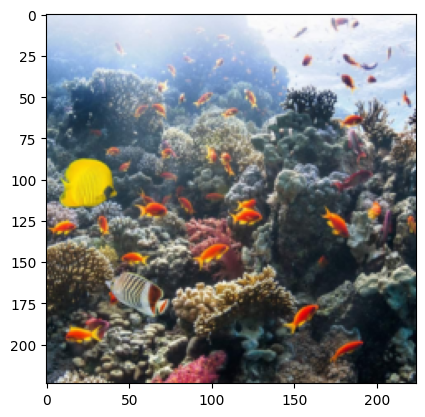

In [19]:
plt.imshow(image_center_resized)
plt.show()

In [20]:
%autoreload 2
from male import associate_channels
x = associate_channels(input_batch=input_batch, 
                       prev_layer=model.layer3[1].conv2, 
                       prev_out_channels=256,
                       curr_layer=model.layer4[0].conv1, 
                       target_ch_id=15, 
                       model=model)
print(tops := list(torch.argsort(x).numpy())[:10])

[21, 122, 244, 144, 205, 210, 192, 153, 200, 92]


In [21]:
query = descriptions[descriptions['layer'] == 'layer3']
tops = list(torch.argsort(x).numpy())[:10]
print(tops)
query =  query[query['unit'].isin(tops)]
query

[21, 122, 244, 144, 205, 210, 192, 153, 200, 92]


,layer,unit,description
277,layer3,21,Striped and checkered objects
348,layer3,92,The tops of objects
378,layer3,122,Diagonal lines
400,layer3,144,The tops of objects
409,layer3,153,The center part of flowers
448,layer3,192,Circles
456,layer3,200,Clothing
461,layer3,205,Beaks
466,layer3,210,Rounded edges in pictures
500,layer3,244,Rounded edges in pictures


<BarContainer object of 256 artists>

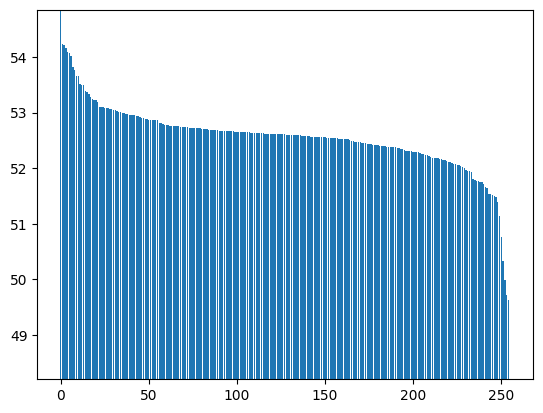

In [22]:
import matplotlib.pyplot as plt
y = list(x)
y.sort(reverse=True)
plt.ylim(min(y), max(y))
plt.bar(range(len(y)), y)

In [23]:
y

[tensor(54.8496),
 tensor(54.2370),
 tensor(54.2202),
 tensor(54.1559),
 tensor(54.0828),
 tensor(54.0743),
 tensor(54.0182),
 tensor(53.8110),
 tensor(53.7727),
 tensor(53.6617),
 tensor(53.6598),
 tensor(53.5104),
 tensor(53.5000),
 tensor(53.4966),
 tensor(53.3938),
 tensor(53.3772),
 tensor(53.3318),
 tensor(53.2790),
 tensor(53.2379),
 tensor(53.2330),
 tensor(53.2225),
 tensor(53.1945),
 tensor(53.1033),
 tensor(53.0949),
 tensor(53.0927),
 tensor(53.0830),
 tensor(53.0747),
 tensor(53.0736),
 tensor(53.0631),
 tensor(53.0611),
 tensor(53.0457),
 tensor(53.0441),
 tensor(53.0209),
 tensor(53.0184),
 tensor(53.0110),
 tensor(52.9987),
 tensor(52.9833),
 tensor(52.9701),
 tensor(52.9679),
 tensor(52.9646),
 tensor(52.9570),
 tensor(52.9536),
 tensor(52.9534),
 tensor(52.9437),
 tensor(52.9351),
 tensor(52.9189),
 tensor(52.9022),
 tensor(52.8969),
 tensor(52.8923),
 tensor(52.8801),
 tensor(52.8752),
 tensor(52.8742),
 tensor(52.8700),
 tensor(52.8638),
 tensor(52.8589),
 tensor(52